# Exeriments : preprocessing + models

## Feature Engineering


In [1]:
import pandas as pd
import numpy as np
from pathlib import Path
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import MultiLabelBinarizer, StandardScaler, OneHotEncoder
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
import joblib
import time
import boto3
import warnings
warnings.filterwarnings('ignore')

# MLflow imports
import mlflow
import mlflow.sklearn
from datetime import datetime

# Set MLflow tracking URI to remote EC2 server
MLFLOW_TRACKING_URI = "http://ec2-63-35-236-114.eu-west-1.compute.amazonaws.com:5000"
mlflow.set_tracking_uri(MLFLOW_TRACKING_URI)
print(f"MLflow Tracking URI: {MLFLOW_TRACKING_URI}")
mlflow.set_experiment("movie-rating-experiments")

# Load data
data_path = Path("../data/raw/movies.csv")
df = pd.read_csv(data_path)
df.columns = [col.lower() for col in df.columns]

df['vote_average'] = pd.to_numeric(df['vote_average'], errors='coerce')
df = df[~df.vote_average.isna()]
df = df[df['vote_average'] != 0]

print(f"\nDataset shape: {df.shape}")
print(f"vote_average dtype: {df['vote_average'].dtype}")

# Split data into X and y BEFORE pipeline transformation
X = df.drop('vote_average', axis=1)
y = df['vote_average']

# Train/test split
RANDOM_STATE = 42
TEST_SIZE = 0.2
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=TEST_SIZE, random_state=RANDOM_STATE)

print(f"\nTraining set size: {len(X_train)}")
print(f"Test set size: {len(X_test)}")
X_train.head()


MLflow Tracking URI: http://ec2-63-35-236-114.eu-west-1.compute.amazonaws.com:5000

Dataset shape: (9726, 9)
vote_average dtype: float64

Training set size: 7780
Test set size: 1946


,release_date,title,overview,popularity,vote_count,original_language,genre,poster_url
5144,1986-07-30,Flight of the Navigator,12-year-old David is accidentally knocked out ...,20.522,618,en,"Family, Science Fiction, Adventure",https://image.tmdb.org/t/p/original/dS4jmRcEAm...
5780,1993-01-01,Farewell My Concubine,"Abandoned by his prostitute mother in 1920, Do...",19.009,353,zh,Drama,https://image.tmdb.org/t/p/original/f54hNIiHNI...
1589,2016-05-13,Justice League vs. Teen Titans,Robin is sent by Batman to work with the Teen ...,48.531,684,en,"Science Fiction, Action, Animation",https://image.tmdb.org/t/p/original/3G6RPpafXA...
2146,2009-09-29,Superman/Batman: Public Enemies,United States President Lex Luthor uses the on...,38.864,476,en,"Science Fiction, Animation, Action, Adventure,...",https://image.tmdb.org/t/p/original/izvMc22ywS...
6482,1967-12-20,Asterix the Gaul,"In the year 50 BC, Gaul is occupied by the Rom...",17.614,536,fr,"Family, Animation, Adventure, Comedy",https://image.tmdb.org/t/p/original/jBDZ68iRPE...


In [2]:
# Save test and train data
X_train.to_csv('../data/processed/X_train.csv', index=False)
X_test.to_csv('../data/processed/X_test.csv', index=False)
y_train.to_csv('../data/processed/y_train.csv', index=False)
y_test.to_csv('../data/processed/y_test.csv', index=False)

### Custom Transformers


In [3]:
# Import custom transformers from src module
import sys
from pathlib import Path
import importlib

# Add parent directory to path to import from src
sys.path.insert(0, str(Path.cwd().parent))

# Force reload the transformers module to pick up any changes (removes cached version)
if 'src.transformers' in sys.modules:
    importlib.reload(sys.modules['src.transformers'])
if 'src' in sys.modules:
    importlib.reload(sys.modules['src'])

# Import custom transformers (TF-IDF only, no embeddings)
from src.transformers import (
    ColumnSelector,
    DataTypeFixer,
    YearBinning,
    GenreMultiLabelEncoder,
    LanguageGrouper,
    LightweightTextEmbedder,
    SelectiveStandardScaler,
    CategoricalOneHotEncoder,
)

print("Custom transformers imported from src.transformers")

Custom transformers imported from src.transformers


### Build the Feature Engineering Pipeline


In [4]:
# Define pipeline configurations
columns_to_keep = ['release_date', 'title', 'overview', 'original_language', 'genre']

# Base hyperparameters
LANGUAGE_THRESHOLD = 0.01

def build_tfidf_pipeline(
    overview_max_features=50,
    title_max_features=30,
    overview_ngram_range=(1, 1),
    title_ngram_range=(1, 1),
    version_suffix=''
):
    """
    Build TF-IDF feature engineering pipeline with configurable parameters.
    
    Args:
        overview_max_features: Max TF-IDF features for overview text
        title_max_features: Max TF-IDF features for title text
        overview_ngram_range: N-gram range for overview (e.g., (1,1) for unigrams, (1,2) for bigrams)
        title_ngram_range: N-gram range for title
        version_suffix: Suffix for pipeline version name
    
    Returns:
        sklearn Pipeline
    """
    return Pipeline([
        ('select_columns', ColumnSelector(columns=columns_to_keep)),
        ('fix_dtypes', DataTypeFixer()),
        ('bin_years', YearBinning()),
        ('encode_genres', GenreMultiLabelEncoder()),
        ('group_languages', LanguageGrouper(threshold=LANGUAGE_THRESHOLD)),
        ('embed_overview', LightweightTextEmbedder(
            column='overview', 
            max_features=overview_max_features,
            ngram_range=overview_ngram_range,
            prefix='overview'
        )),
        ('embed_title', LightweightTextEmbedder(
            column='title', 
            max_features=title_max_features,
            ngram_range=title_ngram_range,
            prefix='title'
        )),
        ('onehot_encode', CategoricalOneHotEncoder(columns=['year_bin', 'original_language'])),
        ('scale_features', SelectiveStandardScaler()),
    ])

# Define experiment configurations
# Easy to add new experiments by adding entries here
EXPERIMENT_CONFIGS = {
    'v1_original': {
        'name': 'Baseline (Unigrams)',
        'overview_max_features': 50,
        'title_max_features': 30,
        'overview_ngram_range': (1, 1),
        'title_ngram_range': (1, 1),
        'description': 'Baseline: Unigrams only, 50 overview + 30 title features'
    },
    'v2_bigrams': {
        'name': 'Bigrams',
        'overview_max_features': 50,
        'title_max_features': 30,
        'overview_ngram_range': (1, 2),
        'title_ngram_range': (1, 2),
        'description': 'Unigrams + Bigrams, 50 overview + 30 title features'
    },
    'v3_bigrams_more_features': {
        'name': 'More Features (Bigrams)',
        'overview_max_features': 100,
        'title_max_features': 30,
        'overview_ngram_range': (1, 2),
        'title_ngram_range': (1, 2),
        'description': 'Unigrams + Bigrams, 100 overview + 50 title features'
    },
    'v4_trigrams': {
        'name': 'Trigrams',
        'overview_max_features': 50,
        'title_max_features': 30,
        'overview_ngram_range': (1, 3),
        'title_ngram_range': (1, 3),
        'description': 'Unigrams + Bigrams + Trigrams, 50 overview + 30 title features'
    },
}

# Build pipeline versions dictionary
PIPELINE_VERSIONS = {}
for version_key, config in EXPERIMENT_CONFIGS.items():
    # Create a closure-safe builder function
    def make_builder(cfg):
        def builder():
            return build_tfidf_pipeline(
                overview_max_features=cfg['overview_max_features'],
                title_max_features=cfg['title_max_features'],
                overview_ngram_range=cfg['overview_ngram_range'],
                title_ngram_range=cfg['title_ngram_range']
            )
        return builder
    
    PIPELINE_VERSIONS[version_key] = {
        'name': config['name'],
        'builder': make_builder(config),
        'description': config['description'],
        'config': config
    }

print(f"Configured {len(PIPELINE_VERSIONS)} pipeline experiments:")
for key, version in PIPELINE_VERSIONS.items():
    print(f"  - {key}: {version['name']}")

Configured 4 pipeline experiments:
  - v1_original: Baseline (Unigrams)
  - v2_bigrams: Bigrams
  - v3_bigrams_more_features: More Features (Bigrams)
  - v4_trigrams: Trigrams


## Fit Feature Engineering Pipelines and Train Models

1. Fit each preprocessing pipeline version
2. Transform the data
3. Train multiple models on each transformed dataset
4. Compare results across all pipeline + model combinations


In [5]:
# Import model training dependencies
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import cross_val_score
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import xgboost as xgb
import lightgbm as lgb

# Set visualization style
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (12, 6)

# Define models to train
def get_models():
    """Return models to train"""
    models = {
        'Linear Regression': LinearRegression(),
        'Ridge': Ridge(alpha=1.0, random_state=RANDOM_STATE),
        'Lasso': Lasso(alpha=0.01, random_state=RANDOM_STATE, max_iter=5000),
        'ElasticNet': ElasticNet(alpha=0.01, l1_ratio=0.5, random_state=RANDOM_STATE, max_iter=5000),
        'Decision Tree': DecisionTreeRegressor(max_depth=10, min_samples_split=20, random_state=RANDOM_STATE),
        'Random Forest': RandomForestRegressor(n_estimators=100, max_depth=15, min_samples_split=10,
                                               min_samples_leaf=4, random_state=RANDOM_STATE, n_jobs=-1),
        'XGBoost': xgb.XGBRegressor(
            n_estimators=100, max_depth=6, learning_rate=0.1,
            subsample=0.8, colsample_bytree=0.8,
            random_state=RANDOM_STATE, n_jobs=-1
        ),
        'LightGBM': lgb.LGBMRegressor(
            n_estimators=100, max_depth=6, learning_rate=0.1,
            num_leaves=31, subsample=0.8, colsample_bytree=0.8,
            random_state=RANDOM_STATE, n_jobs=-1, verbose=-1
        )
    }
    return models

In [6]:
# Fit pipelines, transform data, and train models
all_results = []
processed_data_dir = Path('../data/processed')
processed_data_dir.mkdir(parents=True, exist_ok=True)

# Get models to train
models = get_models()

# Process each pipeline version
for version_key, pipeline_config in PIPELINE_VERSIONS.items():
    print(f"\n{'='*70}")
    print(f"PROCESSING: {pipeline_config['name']} ({version_key})")
    print(f"{'='*70}")
    print(f"Description: {pipeline_config['description']}")
    
    # Build and fit pipeline
    print(f"\n[1/3] Fitting feature engineering pipeline...")
    pipeline = pipeline_config['builder']()
    start_time = time.time()
    X_train_transformed = pipeline.fit_transform(X_train)
    X_test_transformed = pipeline.transform(X_test)
    pipeline_fit_time = time.time() - start_time
    
    print(f"  Pipeline fitted in {pipeline_fit_time:.2f}s")
    print(f"  Features: {X_train.shape[1]} → {X_train_transformed.shape[1]}")
    
    # Save transformed data
    print(f"\n[2/3] Saving transformed data...")
    X_train_path = processed_data_dir / f'X_train_transformed_{version_key}.csv'
    X_test_path = processed_data_dir / f'X_test_transformed_{version_key}.csv'
    X_train_transformed.to_csv(X_train_path, index=False)
    X_test_transformed.to_csv(X_test_path, index=False)
    print(f"  Saved: {X_train_path.name}, {X_test_path.name}")

    
    # Train models on this transformed data
    print(f"\n[3/3] Training {len(models)} models on {version_key} data...")
    print(f"  Train shape: {X_train_transformed.shape}, Test shape: {X_test_transformed.shape}\n")
    
    for model_name, model in models.items():
        try:
            # Start MLflow run for this pipeline + model combination
            with mlflow.start_run(run_name=f"{version_key}_{model_name}_{datetime.now().strftime('%Y%m%d_%H%M%S')}"):
                # Log pipeline parameters
                mlflow.log_param("pipeline_version", version_key)
                mlflow.log_param("pipeline_name", pipeline_config['name'])
                mlflow.log_param("model_name", model_name)
                mlflow.log_param("random_state", RANDOM_STATE)
                mlflow.log_param("n_features", X_train_transformed.shape[1])
                
                # Log TF-IDF configuration
                exp_config = pipeline_config['config']
                mlflow.log_param("overview_max_features", exp_config['overview_max_features'])
                mlflow.log_param("title_max_features", exp_config['title_max_features'])
                mlflow.log_param("overview_ngram_range", str(exp_config['overview_ngram_range']))
                mlflow.log_param("title_ngram_range", str(exp_config['title_ngram_range']))
                
                # Train model
                train_start = time.time()
                model.fit(X_train_transformed, y_train)
                training_time = time.time() - train_start
                
                # Predictions
                y_train_pred = model.predict(X_train_transformed)
                y_test_pred = model.predict(X_test_transformed)
                
                # Metrics
                train_rmse = np.sqrt(mean_squared_error(y_train, y_train_pred))
                train_mae = mean_absolute_error(y_train, y_train_pred)
                train_r2 = r2_score(y_train, y_train_pred)
                
                test_rmse = np.sqrt(mean_squared_error(y_test, y_test_pred))
                test_mae = mean_absolute_error(y_test, y_test_pred)
                test_r2 = r2_score(y_test, y_test_pred)
                
                # Cross-validation
                cv_scores = cross_val_score(
                    model, X_train_transformed, y_train,
                    cv=5,
                    scoring='neg_root_mean_squared_error',
                    n_jobs=-1
                )
                cv_rmse = -cv_scores
                cv_rmse_mean = cv_rmse.mean()
                cv_rmse_std = cv_rmse.std()
                
                # Log metrics
                mlflow.log_metric("train_rmse", train_rmse)
                mlflow.log_metric("train_mae", train_mae)
                mlflow.log_metric("train_r2", train_r2)
                mlflow.log_metric("test_rmse", test_rmse)
                mlflow.log_metric("test_mae", test_mae)
                mlflow.log_metric("test_r2", test_r2)
                mlflow.log_metric("cv_rmse_mean", cv_rmse_mean)
                mlflow.log_metric("cv_rmse_std", cv_rmse_std)
                mlflow.log_metric("training_time", training_time)
                mlflow.log_metric("pipeline_fit_time", pipeline_fit_time)
                
                # Log model
                mlflow.sklearn.log_model(sk_model=model, name="model")
                
                # Store results
                all_results.append({
                    'pipeline_version': version_key,
                    'pipeline_name': pipeline_config['name'],
                    'model_name': model_name,
                    'train_rmse': train_rmse,
                    'train_mae': train_mae,
                    'train_r2': train_r2,
                    'test_rmse': test_rmse,
                    'test_mae': test_mae,
                    'test_r2': test_r2,
                    'cv_rmse_mean': cv_rmse_mean,
                    'cv_rmse_std': cv_rmse_std,
                    'training_time': training_time,
                    'pipeline_fit_time': pipeline_fit_time,
                    'n_features': X_train_transformed.shape[1],
                    'model': model,
                    'pipeline': pipeline
                })
                
                print(f"v {model_name:20s} | Test RMSE: {test_rmse:.4f} | MAE: {test_mae:.4f} | R²: {test_r2:.4f} | Time: {training_time:.1f}s")
                
        except Exception as e:
            print(f"x {model_name:20s} | Error: {str(e)[:50]}")
            continue

print(f"\n{'='*70}")
print(f"EXPERIMENTS COMPLETE!")
print(f"Total combinations tested: {len(all_results)}")
print(f"{'='*70}")



PROCESSING: Baseline (Unigrams) (v1_original)
Description: Baseline: Unigrams only, 50 overview + 30 title features

[1/3] Fitting feature engineering pipeline...
  Pipeline fitted in 0.63s
  Features: 8 → 119

[2/3] Saving transformed data...
  Saved: X_train_transformed_v1_original.csv, X_test_transformed_v1_original.csv

[3/3] Training 8 models on v1_original data...
  Train shape: (7780, 119), Test shape: (1946, 119)



2026/01/10 19:36:07 WARNING mlflow.utils.environment: Failed to resolve installed pip version. ``pip`` will be added to conda.yaml environment spec without a version specifier.


v Linear Regression    | Test RMSE: 0.8512 | MAE: 0.6349 | R²: 0.1916 | Time: 0.0s
🏃 View run v1_original_Linear Regression_20260110_193559 at: http://ec2-63-35-236-114.eu-west-1.compute.amazonaws.com:5000/#/experiments/2/runs/0ba99c4635f74d709eca396e7055bfb4
🧪 View experiment at: http://ec2-63-35-236-114.eu-west-1.compute.amazonaws.com:5000/#/experiments/2


2026/01/10 19:36:15 WARNING mlflow.utils.environment: Failed to resolve installed pip version. ``pip`` will be added to conda.yaml environment spec without a version specifier.


v Ridge                | Test RMSE: 0.8512 | MAE: 0.6348 | R²: 0.1918 | Time: 0.0s
🏃 View run v1_original_Ridge_20260110_193608 at: http://ec2-63-35-236-114.eu-west-1.compute.amazonaws.com:5000/#/experiments/2/runs/61b57dad1ae24c24b5b9cf1c5ef02ac4
🧪 View experiment at: http://ec2-63-35-236-114.eu-west-1.compute.amazonaws.com:5000/#/experiments/2


2026/01/10 19:36:22 WARNING mlflow.utils.environment: Failed to resolve installed pip version. ``pip`` will be added to conda.yaml environment spec without a version specifier.


v Lasso                | Test RMSE: 0.8540 | MAE: 0.6411 | R²: 0.1864 | Time: 0.0s
🏃 View run v1_original_Lasso_20260110_193616 at: http://ec2-63-35-236-114.eu-west-1.compute.amazonaws.com:5000/#/experiments/2/runs/645bb9bf30c547ad9e0923a5f2e93112
🧪 View experiment at: http://ec2-63-35-236-114.eu-west-1.compute.amazonaws.com:5000/#/experiments/2


2026/01/10 19:36:29 WARNING mlflow.utils.environment: Failed to resolve installed pip version. ``pip`` will be added to conda.yaml environment spec without a version specifier.


v ElasticNet           | Test RMSE: 0.8530 | MAE: 0.6389 | R²: 0.1882 | Time: 0.0s
🏃 View run v1_original_ElasticNet_20260110_193623 at: http://ec2-63-35-236-114.eu-west-1.compute.amazonaws.com:5000/#/experiments/2/runs/96cf8ea5042c4b94a19ceeabe23fd692
🧪 View experiment at: http://ec2-63-35-236-114.eu-west-1.compute.amazonaws.com:5000/#/experiments/2


2026/01/10 19:36:35 WARNING mlflow.utils.environment: Failed to resolve installed pip version. ``pip`` will be added to conda.yaml environment spec without a version specifier.


v Decision Tree        | Test RMSE: 0.8957 | MAE: 0.6573 | R²: 0.1050 | Time: 0.0s
🏃 View run v1_original_Decision Tree_20260110_193630 at: http://ec2-63-35-236-114.eu-west-1.compute.amazonaws.com:5000/#/experiments/2/runs/deb1c799dff84428ac33ad5b9087c92d
🧪 View experiment at: http://ec2-63-35-236-114.eu-west-1.compute.amazonaws.com:5000/#/experiments/2


2026/01/10 19:36:44 WARNING mlflow.utils.environment: Failed to resolve installed pip version. ``pip`` will be added to conda.yaml environment spec without a version specifier.


v Random Forest        | Test RMSE: 0.8458 | MAE: 0.6271 | R²: 0.2019 | Time: 0.4s
🏃 View run v1_original_Random Forest_20260110_193636 at: http://ec2-63-35-236-114.eu-west-1.compute.amazonaws.com:5000/#/experiments/2/runs/f9b1c055b96e479fb7b4bf412c17bd1f
🧪 View experiment at: http://ec2-63-35-236-114.eu-west-1.compute.amazonaws.com:5000/#/experiments/2


2026/01/10 19:36:53 WARNING mlflow.utils.environment: Failed to resolve installed pip version. ``pip`` will be added to conda.yaml environment spec without a version specifier.


v XGBoost              | Test RMSE: 0.8456 | MAE: 0.6287 | R²: 0.2024 | Time: 0.4s
🏃 View run v1_original_XGBoost_20260110_193646 at: http://ec2-63-35-236-114.eu-west-1.compute.amazonaws.com:5000/#/experiments/2/runs/c4a2793dc74a488393f6e580c99347e3
🧪 View experiment at: http://ec2-63-35-236-114.eu-west-1.compute.amazonaws.com:5000/#/experiments/2


2026/01/10 19:37:01 WARNING mlflow.utils.environment: Failed to resolve installed pip version. ``pip`` will be added to conda.yaml environment spec without a version specifier.


v LightGBM             | Test RMSE: 0.8414 | MAE: 0.6265 | R²: 0.2102 | Time: 0.4s
🏃 View run v1_original_LightGBM_20260110_193654 at: http://ec2-63-35-236-114.eu-west-1.compute.amazonaws.com:5000/#/experiments/2/runs/6d29e068a86349108bdd3e06f8b7e84c
🧪 View experiment at: http://ec2-63-35-236-114.eu-west-1.compute.amazonaws.com:5000/#/experiments/2

PROCESSING: Bigrams (v2_bigrams)
Description: Unigrams + Bigrams, 50 overview + 30 title features

[1/3] Fitting feature engineering pipeline...
  Pipeline fitted in 1.17s
  Features: 8 → 119

[2/3] Saving transformed data...
  Saved: X_train_transformed_v2_bigrams.csv, X_test_transformed_v2_bigrams.csv

[3/3] Training 8 models on v2_bigrams data...
  Train shape: (7780, 119), Test shape: (1946, 119)



2026/01/10 19:37:10 WARNING mlflow.utils.environment: Failed to resolve installed pip version. ``pip`` will be added to conda.yaml environment spec without a version specifier.


v Linear Regression    | Test RMSE: 0.8505 | MAE: 0.6347 | R²: 0.1931 | Time: 0.0s
🏃 View run v2_bigrams_Linear Regression_20260110_193704 at: http://ec2-63-35-236-114.eu-west-1.compute.amazonaws.com:5000/#/experiments/2/runs/3db4ae03362f40a0b824624a27f17d21
🧪 View experiment at: http://ec2-63-35-236-114.eu-west-1.compute.amazonaws.com:5000/#/experiments/2


2026/01/10 19:37:17 WARNING mlflow.utils.environment: Failed to resolve installed pip version. ``pip`` will be added to conda.yaml environment spec without a version specifier.


v Ridge                | Test RMSE: 0.8504 | MAE: 0.6347 | R²: 0.1932 | Time: 0.0s
🏃 View run v2_bigrams_Ridge_20260110_193711 at: http://ec2-63-35-236-114.eu-west-1.compute.amazonaws.com:5000/#/experiments/2/runs/1ab9892e7b49486387fe1f0ab8c41451
🧪 View experiment at: http://ec2-63-35-236-114.eu-west-1.compute.amazonaws.com:5000/#/experiments/2


2026/01/10 19:37:23 WARNING mlflow.utils.environment: Failed to resolve installed pip version. ``pip`` will be added to conda.yaml environment spec without a version specifier.


v Lasso                | Test RMSE: 0.8540 | MAE: 0.6411 | R²: 0.1864 | Time: 0.0s
🏃 View run v2_bigrams_Lasso_20260110_193718 at: http://ec2-63-35-236-114.eu-west-1.compute.amazonaws.com:5000/#/experiments/2/runs/4844cc2040924f2dac053e7366e517e4
🧪 View experiment at: http://ec2-63-35-236-114.eu-west-1.compute.amazonaws.com:5000/#/experiments/2


2026/01/10 19:37:30 WARNING mlflow.utils.environment: Failed to resolve installed pip version. ``pip`` will be added to conda.yaml environment spec without a version specifier.


v ElasticNet           | Test RMSE: 0.8530 | MAE: 0.6389 | R²: 0.1883 | Time: 0.0s
🏃 View run v2_bigrams_ElasticNet_20260110_193724 at: http://ec2-63-35-236-114.eu-west-1.compute.amazonaws.com:5000/#/experiments/2/runs/210005b7132c40358a3f7c25f5d10a08
🧪 View experiment at: http://ec2-63-35-236-114.eu-west-1.compute.amazonaws.com:5000/#/experiments/2


2026/01/10 19:37:36 WARNING mlflow.utils.environment: Failed to resolve installed pip version. ``pip`` will be added to conda.yaml environment spec without a version specifier.


v Decision Tree        | Test RMSE: 0.8992 | MAE: 0.6602 | R²: 0.0981 | Time: 0.1s
🏃 View run v2_bigrams_Decision Tree_20260110_193731 at: http://ec2-63-35-236-114.eu-west-1.compute.amazonaws.com:5000/#/experiments/2/runs/9ffd95d9246f4474aef21141b079366d
🧪 View experiment at: http://ec2-63-35-236-114.eu-west-1.compute.amazonaws.com:5000/#/experiments/2


2026/01/10 19:37:45 WARNING mlflow.utils.environment: Failed to resolve installed pip version. ``pip`` will be added to conda.yaml environment spec without a version specifier.


v Random Forest        | Test RMSE: 0.8462 | MAE: 0.6277 | R²: 0.2012 | Time: 0.4s
🏃 View run v2_bigrams_Random Forest_20260110_193737 at: http://ec2-63-35-236-114.eu-west-1.compute.amazonaws.com:5000/#/experiments/2/runs/647560eb25cb4cc1946685044910a3a1
🧪 View experiment at: http://ec2-63-35-236-114.eu-west-1.compute.amazonaws.com:5000/#/experiments/2


2026/01/10 19:37:53 WARNING mlflow.utils.environment: Failed to resolve installed pip version. ``pip`` will be added to conda.yaml environment spec without a version specifier.


v XGBoost              | Test RMSE: 0.8504 | MAE: 0.6339 | R²: 0.1932 | Time: 0.3s
🏃 View run v2_bigrams_XGBoost_20260110_193747 at: http://ec2-63-35-236-114.eu-west-1.compute.amazonaws.com:5000/#/experiments/2/runs/4fe2636c011b4973aad7e0c84bedcb5f
🧪 View experiment at: http://ec2-63-35-236-114.eu-west-1.compute.amazonaws.com:5000/#/experiments/2


2026/01/10 19:38:01 WARNING mlflow.utils.environment: Failed to resolve installed pip version. ``pip`` will be added to conda.yaml environment spec without a version specifier.


v LightGBM             | Test RMSE: 0.8408 | MAE: 0.6265 | R²: 0.2113 | Time: 0.4s
🏃 View run v2_bigrams_LightGBM_20260110_193754 at: http://ec2-63-35-236-114.eu-west-1.compute.amazonaws.com:5000/#/experiments/2/runs/667caefc1d5642e3b1b205213794bb16
🧪 View experiment at: http://ec2-63-35-236-114.eu-west-1.compute.amazonaws.com:5000/#/experiments/2

PROCESSING: More Features (Bigrams) (v3_bigrams_more_features)
Description: Unigrams + Bigrams, 100 overview + 50 title features

[1/3] Fitting feature engineering pipeline...
  Pipeline fitted in 1.00s
  Features: 8 → 169

[2/3] Saving transformed data...
  Saved: X_train_transformed_v3_bigrams_more_features.csv, X_test_transformed_v3_bigrams_more_features.csv

[3/3] Training 8 models on v3_bigrams_more_features data...
  Train shape: (7780, 169), Test shape: (1946, 169)



2026/01/10 19:38:10 WARNING mlflow.utils.environment: Failed to resolve installed pip version. ``pip`` will be added to conda.yaml environment spec without a version specifier.


v Linear Regression    | Test RMSE: 0.8510 | MAE: 0.6359 | R²: 0.1921 | Time: 0.0s
🏃 View run v3_bigrams_more_features_Linear Regression_20260110_193804 at: http://ec2-63-35-236-114.eu-west-1.compute.amazonaws.com:5000/#/experiments/2/runs/18b0b4639e2843d5b49cb19b63f49c40
🧪 View experiment at: http://ec2-63-35-236-114.eu-west-1.compute.amazonaws.com:5000/#/experiments/2


2026/01/10 19:38:16 WARNING mlflow.utils.environment: Failed to resolve installed pip version. ``pip`` will be added to conda.yaml environment spec without a version specifier.


v Ridge                | Test RMSE: 0.8508 | MAE: 0.6357 | R²: 0.1925 | Time: 0.0s
🏃 View run v3_bigrams_more_features_Ridge_20260110_193811 at: http://ec2-63-35-236-114.eu-west-1.compute.amazonaws.com:5000/#/experiments/2/runs/6e30984b05ad45f4989f5db2143494aa
🧪 View experiment at: http://ec2-63-35-236-114.eu-west-1.compute.amazonaws.com:5000/#/experiments/2


2026/01/10 19:38:23 WARNING mlflow.utils.environment: Failed to resolve installed pip version. ``pip`` will be added to conda.yaml environment spec without a version specifier.


v Lasso                | Test RMSE: 0.8540 | MAE: 0.6411 | R²: 0.1864 | Time: 0.0s
🏃 View run v3_bigrams_more_features_Lasso_20260110_193817 at: http://ec2-63-35-236-114.eu-west-1.compute.amazonaws.com:5000/#/experiments/2/runs/d58b4905247b4dc7b5df8b7c5af971a3
🧪 View experiment at: http://ec2-63-35-236-114.eu-west-1.compute.amazonaws.com:5000/#/experiments/2


2026/01/10 19:38:29 WARNING mlflow.utils.environment: Failed to resolve installed pip version. ``pip`` will be added to conda.yaml environment spec without a version specifier.


v ElasticNet           | Test RMSE: 0.8532 | MAE: 0.6391 | R²: 0.1878 | Time: 0.0s
🏃 View run v3_bigrams_more_features_ElasticNet_20260110_193824 at: http://ec2-63-35-236-114.eu-west-1.compute.amazonaws.com:5000/#/experiments/2/runs/67873a10a8bc45c1ac1a5ec426a31680
🧪 View experiment at: http://ec2-63-35-236-114.eu-west-1.compute.amazonaws.com:5000/#/experiments/2


2026/01/10 19:38:36 WARNING mlflow.utils.environment: Failed to resolve installed pip version. ``pip`` will be added to conda.yaml environment spec without a version specifier.


v Decision Tree        | Test RMSE: 0.8914 | MAE: 0.6538 | R²: 0.1136 | Time: 0.1s
🏃 View run v3_bigrams_more_features_Decision Tree_20260110_193830 at: http://ec2-63-35-236-114.eu-west-1.compute.amazonaws.com:5000/#/experiments/2/runs/5563bbe748bb4b2e821f5af8d5670aa6
🧪 View experiment at: http://ec2-63-35-236-114.eu-west-1.compute.amazonaws.com:5000/#/experiments/2


2026/01/10 19:38:46 WARNING mlflow.utils.environment: Failed to resolve installed pip version. ``pip`` will be added to conda.yaml environment spec without a version specifier.


v Random Forest        | Test RMSE: 0.8420 | MAE: 0.6266 | R²: 0.2091 | Time: 0.6s
🏃 View run v3_bigrams_more_features_Random Forest_20260110_193837 at: http://ec2-63-35-236-114.eu-west-1.compute.amazonaws.com:5000/#/experiments/2/runs/6d19958f1c2d41c5889abe3b60c41b9d
🧪 View experiment at: http://ec2-63-35-236-114.eu-west-1.compute.amazonaws.com:5000/#/experiments/2


2026/01/10 19:38:54 WARNING mlflow.utils.environment: Failed to resolve installed pip version. ``pip`` will be added to conda.yaml environment spec without a version specifier.


v XGBoost              | Test RMSE: 0.8468 | MAE: 0.6326 | R²: 0.2000 | Time: 0.5s
🏃 View run v3_bigrams_more_features_XGBoost_20260110_193848 at: http://ec2-63-35-236-114.eu-west-1.compute.amazonaws.com:5000/#/experiments/2/runs/5606e2a5a47a4c379ed5003ab46a65bc
🧪 View experiment at: http://ec2-63-35-236-114.eu-west-1.compute.amazonaws.com:5000/#/experiments/2


2026/01/10 19:39:03 WARNING mlflow.utils.environment: Failed to resolve installed pip version. ``pip`` will be added to conda.yaml environment spec without a version specifier.


v LightGBM             | Test RMSE: 0.8396 | MAE: 0.6255 | R²: 0.2135 | Time: 0.5s
🏃 View run v3_bigrams_more_features_LightGBM_20260110_193855 at: http://ec2-63-35-236-114.eu-west-1.compute.amazonaws.com:5000/#/experiments/2/runs/957d722419634f69ba10673b09bb1d3a
🧪 View experiment at: http://ec2-63-35-236-114.eu-west-1.compute.amazonaws.com:5000/#/experiments/2

PROCESSING: Trigrams (v4_trigrams)
Description: Unigrams + Bigrams + Trigrams, 50 overview + 30 title features

[1/3] Fitting feature engineering pipeline...
  Pipeline fitted in 1.64s
  Features: 8 → 119

[2/3] Saving transformed data...
  Saved: X_train_transformed_v4_trigrams.csv, X_test_transformed_v4_trigrams.csv

[3/3] Training 8 models on v4_trigrams data...
  Train shape: (7780, 119), Test shape: (1946, 119)



2026/01/10 19:39:12 WARNING mlflow.utils.environment: Failed to resolve installed pip version. ``pip`` will be added to conda.yaml environment spec without a version specifier.


v Linear Regression    | Test RMSE: 0.8504 | MAE: 0.6344 | R²: 0.1933 | Time: 0.0s
🏃 View run v4_trigrams_Linear Regression_20260110_193906 at: http://ec2-63-35-236-114.eu-west-1.compute.amazonaws.com:5000/#/experiments/2/runs/44caac3d07104f77947e5396856107c5
🧪 View experiment at: http://ec2-63-35-236-114.eu-west-1.compute.amazonaws.com:5000/#/experiments/2


2026/01/10 19:39:18 WARNING mlflow.utils.environment: Failed to resolve installed pip version. ``pip`` will be added to conda.yaml environment spec without a version specifier.


v Ridge                | Test RMSE: 0.8503 | MAE: 0.6344 | R²: 0.1934 | Time: 0.0s
🏃 View run v4_trigrams_Ridge_20260110_193913 at: http://ec2-63-35-236-114.eu-west-1.compute.amazonaws.com:5000/#/experiments/2/runs/f9c8c7b104b74702a9425f187e310ec8
🧪 View experiment at: http://ec2-63-35-236-114.eu-west-1.compute.amazonaws.com:5000/#/experiments/2


2026/01/10 19:39:25 WARNING mlflow.utils.environment: Failed to resolve installed pip version. ``pip`` will be added to conda.yaml environment spec without a version specifier.


v Lasso                | Test RMSE: 0.8540 | MAE: 0.6411 | R²: 0.1864 | Time: 0.0s
🏃 View run v4_trigrams_Lasso_20260110_193919 at: http://ec2-63-35-236-114.eu-west-1.compute.amazonaws.com:5000/#/experiments/2/runs/360115ba056341078fec6d068d814143
🧪 View experiment at: http://ec2-63-35-236-114.eu-west-1.compute.amazonaws.com:5000/#/experiments/2


2026/01/10 19:39:31 WARNING mlflow.utils.environment: Failed to resolve installed pip version. ``pip`` will be added to conda.yaml environment spec without a version specifier.


v ElasticNet           | Test RMSE: 0.8530 | MAE: 0.6389 | R²: 0.1882 | Time: 0.0s
🏃 View run v4_trigrams_ElasticNet_20260110_193925 at: http://ec2-63-35-236-114.eu-west-1.compute.amazonaws.com:5000/#/experiments/2/runs/c007b33b75e548f4b8ef0283c82b4cdd
🧪 View experiment at: http://ec2-63-35-236-114.eu-west-1.compute.amazonaws.com:5000/#/experiments/2


2026/01/10 19:39:37 WARNING mlflow.utils.environment: Failed to resolve installed pip version. ``pip`` will be added to conda.yaml environment spec without a version specifier.


v Decision Tree        | Test RMSE: 0.8938 | MAE: 0.6559 | R²: 0.1087 | Time: 0.0s
🏃 View run v4_trigrams_Decision Tree_20260110_193932 at: http://ec2-63-35-236-114.eu-west-1.compute.amazonaws.com:5000/#/experiments/2/runs/dddbc290598d42c8a9c59c481f580fbd
🧪 View experiment at: http://ec2-63-35-236-114.eu-west-1.compute.amazonaws.com:5000/#/experiments/2


2026/01/10 19:39:46 WARNING mlflow.utils.environment: Failed to resolve installed pip version. ``pip`` will be added to conda.yaml environment spec without a version specifier.


v Random Forest        | Test RMSE: 0.8444 | MAE: 0.6269 | R²: 0.2045 | Time: 0.4s
🏃 View run v4_trigrams_Random Forest_20260110_193938 at: http://ec2-63-35-236-114.eu-west-1.compute.amazonaws.com:5000/#/experiments/2/runs/8e1de207dad94bf2ad55bb00b45d9abb
🧪 View experiment at: http://ec2-63-35-236-114.eu-west-1.compute.amazonaws.com:5000/#/experiments/2


2026/01/10 19:39:54 WARNING mlflow.utils.environment: Failed to resolve installed pip version. ``pip`` will be added to conda.yaml environment spec without a version specifier.


v XGBoost              | Test RMSE: 0.8442 | MAE: 0.6284 | R²: 0.2049 | Time: 0.3s
🏃 View run v4_trigrams_XGBoost_20260110_193948 at: http://ec2-63-35-236-114.eu-west-1.compute.amazonaws.com:5000/#/experiments/2/runs/01492742ca8141bdb83a51c8e72d58a5
🧪 View experiment at: http://ec2-63-35-236-114.eu-west-1.compute.amazonaws.com:5000/#/experiments/2


2026/01/10 19:40:02 WARNING mlflow.utils.environment: Failed to resolve installed pip version. ``pip`` will be added to conda.yaml environment spec without a version specifier.


v LightGBM             | Test RMSE: 0.8367 | MAE: 0.6232 | R²: 0.2191 | Time: 0.4s
🏃 View run v4_trigrams_LightGBM_20260110_193955 at: http://ec2-63-35-236-114.eu-west-1.compute.amazonaws.com:5000/#/experiments/2/runs/e868a772d09d4e6ebe23212a4acd686f
🧪 View experiment at: http://ec2-63-35-236-114.eu-west-1.compute.amazonaws.com:5000/#/experiments/2

EXPERIMENTS COMPLETE!
Total combinations tested: 32


In [7]:
# Create comparison DataFrame
comparison_df = pd.DataFrame([
    {
        'Pipeline': r['pipeline_version'],
        'Pipeline Name': r['pipeline_name'],
        'Model': r['model_name'],
        'Train RMSE': r['train_rmse'],
        'Test RMSE': r['test_rmse'],
        'Train MAE': r['train_mae'],
        'Test MAE': r['test_mae'],
        'Train R²': r['train_r2'],
        'Test R²': r['test_r2'],
        'CV RMSE': r['cv_rmse_mean'],
        'CV Std': r['cv_rmse_std'],
        'Time (s)': r['training_time'],
        'Features': r['n_features']
    }
    for r in all_results
])

# Sort by test RMSE
comparison_df = comparison_df.sort_values('Test RMSE')

# Save to file
models_dir = Path('../models')
models_dir.mkdir(exist_ok=True)
comparison_df.to_csv(models_dir / 'experiment_results_all_combinations.csv', index=False)

print("\n" + "="*100)
print("EXPERIMENT RESULTS (sorted by Test RMSE)")
print("="*100)
print(comparison_df.to_string(index=False))
print("="*100)
print(f"\nResults saved to: {models_dir / 'experiment_results_all_combinations.csv'}")



EXPERIMENT RESULTS (sorted by Test RMSE)
                Pipeline           Pipeline Name             Model  Train RMSE  Test RMSE  Train MAE  Test MAE  Train R²  Test R²  CV RMSE   CV Std  Time (s)  Features
             v4_trigrams                Trigrams          LightGBM    0.742449   0.836674   0.561750  0.623174  0.350809 0.219056 0.810124 0.025695  0.388671       119
v3_bigrams_more_features More Features (Bigrams)          LightGBM    0.738471   0.839647   0.558338  0.625484  0.357748 0.213496 0.813464 0.026637  0.483872       169
              v2_bigrams                 Bigrams          LightGBM    0.741427   0.840820   0.560860  0.626456  0.352596 0.211297 0.811310 0.026042  0.391690       119
             v1_original     Baseline (Unigrams)          LightGBM    0.743017   0.841421   0.561592  0.626518  0.349816 0.210170 0.810233 0.026041  0.436450       119
v3_bigrams_more_features More Features (Bigrams)     Random Forest    0.709440   0.841980   0.537822  0.626590  0.4072

In [8]:
# Get overall best model
best_result = min(all_results, key=lambda x: x['test_rmse'])

print(f"{'='*70}")
print("BEST MODEL OVERALL")
print(f"{'='*70}")
print(f"\nPipeline: {best_result['pipeline_version']} ({best_result['pipeline_name']})")
print(f"Model: {best_result['model_name']}")
print(f"Test RMSE: {best_result['test_rmse']:.4f}")
print(f"Test MAE: {best_result['test_mae']:.4f}")
print(f"Test R²: {best_result['test_r2']:.4f}")
print(f"CV RMSE: {best_result['cv_rmse_mean']:.4f} ± {best_result['cv_rmse_std']:.4f}")
print(f"Training Time: {best_result['training_time']:.2f}s")
print(f"Features: {best_result['n_features']}")

# Create combined pipeline (preprocessing + model)
from sklearn.pipeline import Pipeline 

full_pipeline = Pipeline([
    ('preprocessing', best_result['pipeline']),
    ('model', best_result['model'])
])

# Save combined pipeline using joblib
full_pipeline_path = models_dir / 'production_pipeline_v1.joblib'
joblib.dump(full_pipeline, full_pipeline_path)

print(f"\nv Combined pipeline saved to: {full_pipeline_path}")
print(f"  Pipeline version: {best_result['pipeline_version']} ({best_result['pipeline_name']})")
print(f"  Model: {best_result['model_name']}")
print(f"\nThe model predicts ratings with avg error of {best_result['test_mae']:.2f} points.")
print("="*70)


BEST MODEL OVERALL

Pipeline: v4_trigrams (Trigrams)
Model: LightGBM
Test RMSE: 0.8367
Test MAE: 0.6232
Test R²: 0.2191
CV RMSE: 0.8101 ± 0.0257
Training Time: 0.39s
Features: 119

v Combined pipeline saved to: ../models/production_pipeline_v1.joblib
  Pipeline version: v4_trigrams (Trigrams)
  Model: LightGBM

The model predicts ratings with avg error of 0.62 points.


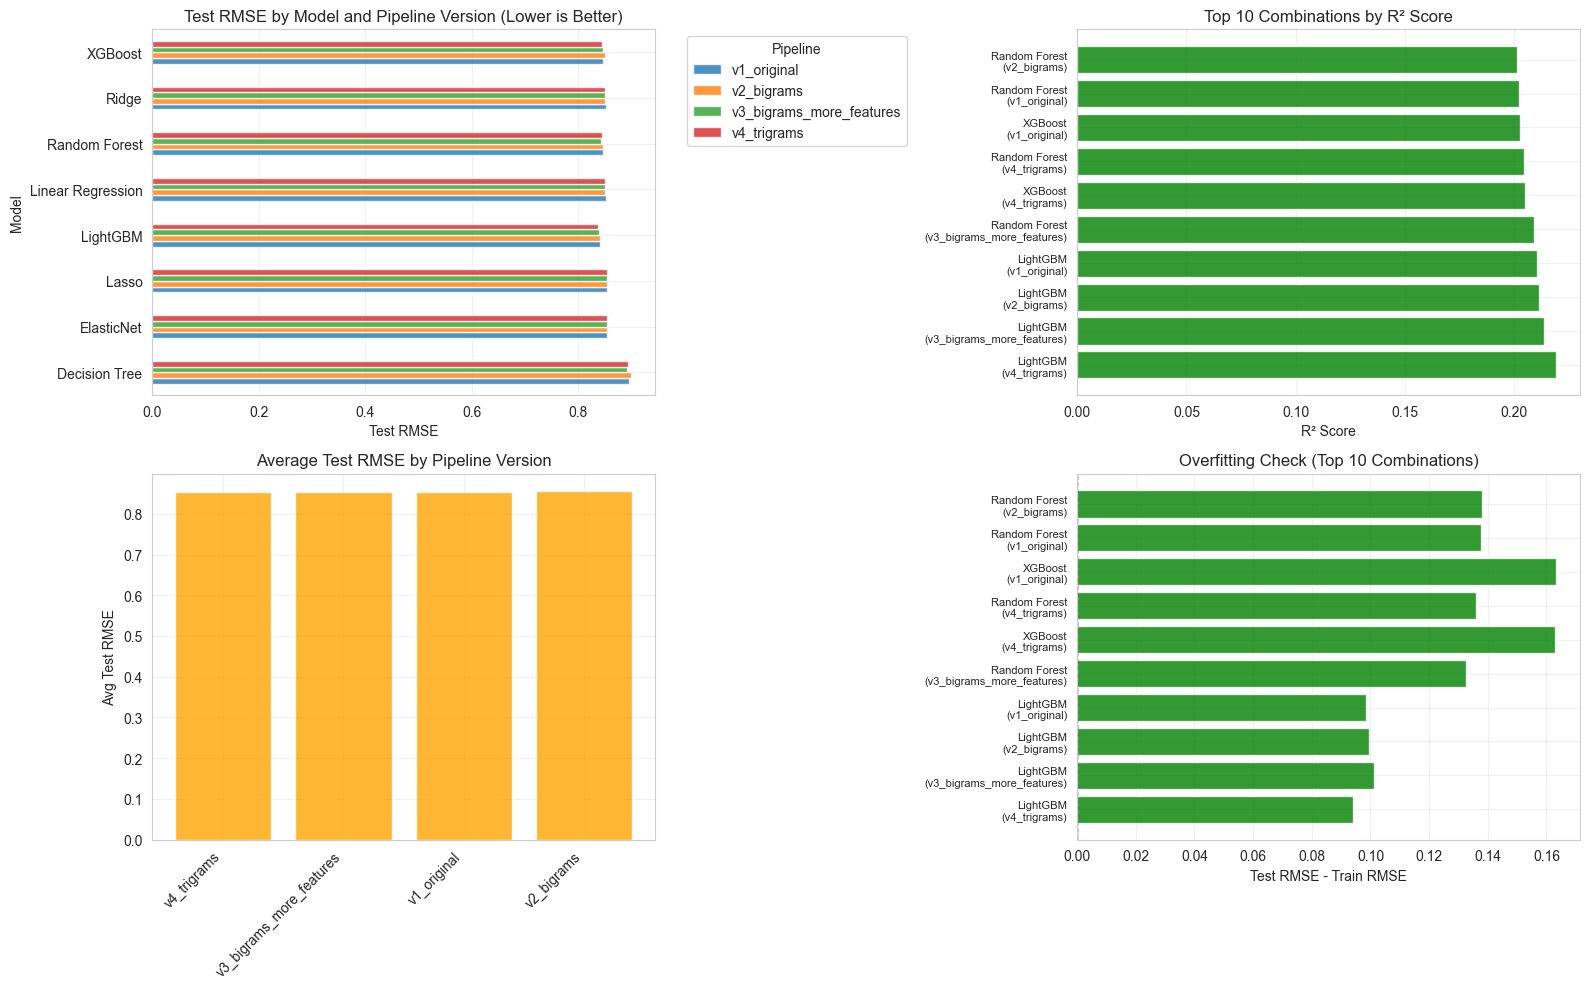

In [9]:
# Visualize results across pipeline versions
fig, axes = plt.subplots(2, 2, figsize=(16, 10))

# 1. Test RMSE by Pipeline and Model
pivot_rmse = comparison_df.pivot_table(
    values='Test RMSE', 
    index='Model', 
    columns='Pipeline', 
    aggfunc='first'
)
pivot_rmse.plot(kind='barh', ax=axes[0, 0], alpha=0.8)
axes[0, 0].set_xlabel('Test RMSE')
axes[0, 0].set_title('Test RMSE by Model and Pipeline Version (Lower is Better)')
axes[0, 0].legend(title='Pipeline', bbox_to_anchor=(1.05, 1), loc='upper left')
axes[0, 0].grid(True, alpha=0.3)

# 2. Top 10 models by R²
top_10 = comparison_df.head(10)
x = np.arange(len(top_10))
axes[0, 1].barh(x, top_10['Test R²'], alpha=0.8, color='green')
axes[0, 1].set_yticks(x)
axes[0, 1].set_yticklabels([f"{row['Model']}\n({row['Pipeline']})" 
                             for _, row in top_10.iterrows()], fontsize=8)
axes[0, 1].set_xlabel('R² Score')
axes[0, 1].set_title('Top 10 Combinations by R² Score')
axes[0, 1].grid(True, alpha=0.3)

# 3. Average performance by pipeline version
pipeline_perf = comparison_df.groupby('Pipeline')['Test RMSE'].mean().sort_values()
axes[1, 0].bar(range(len(pipeline_perf)), pipeline_perf.values, alpha=0.8, color='orange')
axes[1, 0].set_xticks(range(len(pipeline_perf)))
axes[1, 0].set_xticklabels(pipeline_perf.index, rotation=45, ha='right')
axes[1, 0].set_ylabel('Avg Test RMSE')
axes[1, 0].set_title('Average Test RMSE by Pipeline Version')
axes[1, 0].grid(True, alpha=0.3)

# 4. Overfitting check (top 10)
overfit = top_10['Test RMSE'] - top_10['Train RMSE']
colors = ['red' if x > 0.5 else 'yellow' if x > 0.2 else 'green' for x in overfit]
axes[1, 1].barh(x, overfit, alpha=0.8, color=colors)
axes[1, 1].set_yticks(x)
axes[1, 1].set_yticklabels([f"{row['Model']}\n({row['Pipeline']})" 
                             for _, row in top_10.iterrows()], fontsize=8)
axes[1, 1].set_xlabel('Test RMSE - Train RMSE')
axes[1, 1].set_title('Overfitting Check (Top 10 Combinations)')
axes[1, 1].axvline(x=0, color='black', linestyle='--', linewidth=1)
axes[1, 1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()
